## Calculate wetbulb temperature

In [ ]:
import xarray as xr
from metpy.units import units as mpunits
from metpy import calc as mpcalc
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt

In [2]:
from distributed import Client, LocalCluster, progress
cluster = LocalCluster(
    threads_per_worker=1,
    n_workers=1,
    dashboard_address=8644,
    processes=False,
)
client = Client(cluster)
client

In [3]:
# Point to model data
rootdir = '/local/ss23/GFDL_LEs/ATM/RCP85/'
suffix = '.rcp85.ens101.1950_2100.nc'
variables = ['sphum_k24','ps','t_ref']
ds = xr.Dataset()
for var in variables:
    print(var)
    ds[var] = xr.open_dataarray(rootdir+var+suffix,chunks={'time':1000}).squeeze()

sphum_k24
ps
t_ref


In [4]:
ds

,Array,Chunk
Bytes,2.86 GB,51.84 MB
Shape,"(55115, 90, 144)","(1000, 90, 144)"
Count,113 Tasks,56 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,2.86 GB,51.84 MB
Shape,"(55115, 90, 144)","(1000, 90, 144)"
Count,57 Tasks,56 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [18]:
def wet_bulb_temperature_from_specific_humidity(specific_humidity, temperature, pressure):
    qvr = specific_humidity/(1-specific_humidity)
    e = mpcalc.vapor_pressure(pressure,qvr*mpunits('kg/kg'))
    td = mpcalc.dewpoint(e)
    twb = mpcalc.wet_bulb_temperature(pressure,temperature,td)
    return twb

ValueError: `vapor_pressure` given arguments with incorrect units: `pressure` requires "[pressure]" but given "none".
Any variable `x` can be assigned a unit as follows:
    from metpy.units import units
    x = x * units.meter / units.second

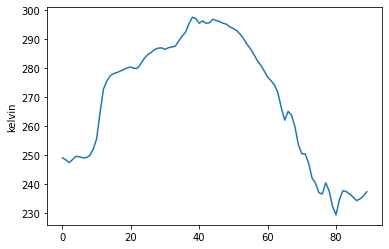

In [26]:
ds_now = ds.isel(time=0,lon=50).load()
%time twb = wet_bulb_temperature_from_specific_humidity(ds_now['sphum_k24'].data,ds_now['t_ref'].data,ds_now['ps'].data)
plt.plot(twb)

IndexError: index -1 is out of bounds for axis 0 with size 0

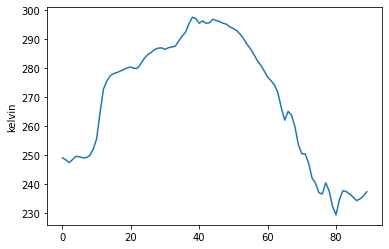

In [23]:
ds_now = ds.isel(time=0,lon=50).load()
%time twb = mpcalc.wet_bulb_temperature(ds_now['ps'].data*mpunits('Pa'),ds_now['t_ref'].data*mpunits('degK'),ds_now['t_ref'].data*mpunits('degK'))
plt.plot(twb)

In [6]:
# Calculate the water vapor mixing ratio from specific humidity
def _mixing_ratio_from_specific_humidity(specific_humidity):
    func = lambda x : (x/(1-x))*mpunits('kg/kg')
    return xr.apply_ufunc(func,
                          specific_humidity,
                          dask='parallelized',output_dtypes=[specific_humidity.dtype])

In [7]:
def _mpcalc_vapor_pressure(pressure,mixing_ratio):
    return xr.apply_ufunc(mpcalc.vapor_pressure,
                      pressure, mixing_ratio,
                      dask='parallelized',output_dtypes=[mixing_ratio.dtype])

In [12]:
def _mpcalc_dewpoint(vapor_pressure):
    return xr.apply_ufunc(mpcalc.dewpoint,
                         vapor_pressure,
                         dask='parallelized',output_dtypes=[vapor_pressure.dtype])

In [13]:
def _mpcalc_wet_bulb_temperature(pressure, temperature, dewpoint):
    return xr.apply_ufunc(mpcalc.wet_bulb_temperature,
                         pressure, temperature, dewpoint,
                         dask='parallelized',output_dtypes=[temperature.dtype])

In [14]:
def mpcalc_wet_bulb_temperature_from_specific_humidity(specific_humidity, temperature, pressure):
    
    # Calculate the water vapor mixing ratio from specific humidity
    mixing_ratio = _mixing_ratio_from_specific_humidity(specific_humidity)
    # Calculate vapor pressure
    vapor_pressure = _mpcalc_vapor_pressure(pressure,mixing_ratio)
    # Calculate dewpoint pressure
    dewpoint = _mpcalc_dewpoint(vapor_pressure)
    # Calculate wet bulb temperature
    wet_bulb_temperature = _mpcalc_wet_bulb_temperature(pressure, temperature, dewpoint)
    
    return wet_bulb_temperature

In [15]:
# %time ds_now['qvr'] = _mixing_ratio_from_specific_humidity(ds_now['sphum_k24'])
# %time vapor_pressure = _mpcalc_vapor_pressure(ds_now['ps']*mpunits('Pa'),ds_now['qvr']*mpunits('kg/kg'))
# %time dewpoint = _mpcalc_dewpoint(vapor_pressure)
%time wet_bulb_temperature = mpcalc_wet_bulb_temperature_from_specific_humidity(ds_now['sphum_k24'],ds_now['t_ref']*mpunits('degK'),ds_now['ps']*mpunits('Pa'))

IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
wet_bulb_temperature.load()

In [26]:
def wet_bulb_temperature_from_specific_humidity(specific_humidity, temperature, pressure):
    return xr.apply_ufunc(_wet_bulb_temperature_from_specific_humidity,
                            specific_humidity, temperature, pressure,
                            dask='parallelized',output_dtypes=[specific_humidity.dtype])

In [27]:
# with ProgressBar():
%time twb = wet_bulb_temperature_from_specific_humidity(ds_now['sphum_k24'].values, ds_now['t_ref'].values*mpunits('degK'), ds_now['ps'].values*mpunits('Pa'))

CPU times: user 3min 58s, sys: 7.07 ms, total: 3min 58s
Wall time: 3min 58s


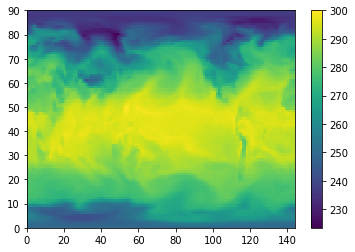

In [28]:
im = plt.pcolormesh(twb)
plt.colorbar(im)